# Modélisation et Suivi des Expérimentations avec MLFlow

Ce notebook est dédié à la modélisation du score de prédiction et au suivi des expérimentations à l'aide de MLFlow. 
L'objectif est de tracer toutes les étapes de modélisation, depuis le prétraitement des données jusqu'à l'entraînement 
et l'évaluation des modèles, tout en enregistrant les résultats dans MLFlow pour faciliter l'analyse et la comparaison.

### Étapes couvertes :
1. Chargement et préparation des données
2. Entraînement des modèles
3. Suivi des expérimentations avec MLFlow
4. Comparaison des modèles et analyse des performances
5. Analyse de la contribution des variables avec SHAP


## Model a try : Dummy classifier , linear regression logistique , random forest classifier et gradiant boosting clasifier (ou ada boost)

 Utiliser : stratified kfold > pour split le dataset > préciser les col sur lesquels stratifié et garder qu'une partie du dataset


 suivre mlflow
 param 
 model 
 metrics 
 

In [1]:
# Import des bibliothèques principales
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, roc_curve, auc, confusion_matrix, make_scorer
from sklearn.preprocessing import MinMaxScaler
import mlflow
import mlflow.sklearn
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import StratifiedKFold
from mlflow.tracking import MlflowClient

from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score


import tqdm as notebook_tqdm

import warnings
warnings.filterwarnings('ignore')

# Initialisation de MLFlow
mlflow.set_tracking_uri("file:./mlruns")  # dossier local pour le tracking
mlflow.set_experiment("Projet_Scoring")

print("Configuration et MLFlow initialisés.")

# augmenter l'allocation mémoire pour améliorer les temps d'éxécution
# Augmenter les limites de numpy et pandas 
np.set_printoptions(threshold=np.inf)
pd.options.display.max_rows = None
pd.options.display.max_columns = None

import psutil
import os
os.environ["PYTHONMALLOC"] = "default"  # allocation mémoire par défaut sans restriction

# Afficher la mémoire totale disponible
total_memory = psutil.virtual_memory().total
print(f"Total memory available: {total_memory / (1024 ** 3):.2f} GB")

Configuration et MLFlow initialisés.
Total memory available: 31.91 GB


## Chargement et Préparation des Donnéestes.


In [2]:
# Chargement des datasets enrichis (features métiers)
domain_features_train = pd.read_csv("ProcessedData/app_train_domain.csv")
domain_features_train = domain_features_train.dropna()
domain_features_test = pd.read_csv("ProcessedData/app_test_domain.csv")
domain_features_test = domain_features_test.dropna()
train_labels = domain_features_train["TARGET"]

# Vérification des dimensions
print(f"Train Shape: {domain_features_train.shape}, Test Shape: {domain_features_test.shape}")
print(f"Labels Shape: {train_labels.shape}")

Train Shape: (10746, 245), Test Shape: (2221, 244)
Labels Shape: (10746,)


## Fonction Standardisée pour le Tracking MLFlow

Suivie des résultat avec MLFlow :
- Hyperparamètres (mlflow.log_params(params))
- Temps de d'éxécution (.fit et .predict_proba)
- Scores 
    - AUC (mlflow.log_metric("AUC", auc_score))
    - Score Métier (mlflow.log_metric("business_score", business_score))
- Model (mlflow.sklearn.log_model(model, "model"))
- Courbes ROC (mlflow.log_artifact("roc_curve.png"))

In [3]:
def track_experiment(model_name, model, params, X_train, y_train, X_test, y_test):
    # Création d'un client MLFlow local
    client = MlflowClient()

    # Récupérer l'expérience MLFlow
    experiment = next((exp for exp in client.search_experiments() if exp.name == model_name), None)
    
    if not experiment:
        experiment_id = mlflow.create_experiment(model_name)
        print(f" Suivi MLFlow : {model_name} (ID: {experiment_id})")
    else:
        experiment_id = experiment.experiment_id
        print(f" Utilisation de l'expérience existante : {model_name} (ID: {experiment_id})")

    with mlflow.start_run(experiment_id=experiment_id, run_name=model_name):
        
        # Hyperparamètres
        mlflow.log_params(params)
        
        # Fit et son temps
        start_fit = time.time()
        model.fit(X_train, y_train)
        fit_time = time.time() - start_fit
        mlflow.log_metric("fit_time", fit_time)
        
        # predict_proba et son temps
        start_pred = time.time()
        y_pred_proba = model.predict_proba(X_test)[:, 1]
        y_pred = model.predict(X_test)
        prediction_time = time.time() - start_pred
        mlflow.log_metric("prediction_time", prediction_time)
        
        # Calcul des scores
        auc_score = roc_auc_score(y_test, y_pred_proba)
        business_score = calculate_business_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        accuracy = accuracy_score(y_test, y_pred)
        auc_test = roc_auc_score(y_test, y_pred_proba)
        threshold_optimal = calculate_optimal_threshold(y_test, y_pred_proba)

        # Enregistrement des scores
        mlflow.log_metric("AUC", auc_score)
        mlflow.log_metric("business_score", business_score)
        mlflow.log_metric("F1", f1)
        mlflow.log_metric("accuracy", accuracy)
        mlflow.log_metric("AUC_test", auc_test)
        mlflow.log_metric("threshold_optimal", threshold_optimal)
        
        # Enregistrement du modèle
        mlflow.sklearn.log_model(model, "model")
        
        # Courbe ROC
        fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
        plt.figure(figsize=(8, 6))
        plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {auc_score:.2f})")
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.title(f"ROC Curve for {model_name}")
        plt.legend()
        plt.grid()
        plt.savefig("roc_curve.png")
        mlflow.log_artifact("roc_curve.png")
        plt.show()  # display dans le notebook
        
        print(f" {model_name} enregistré dans MLFlow")
        return model

## Score métier

In [4]:
# Fonction de calcul du coût / score métier
def calculate_business_score(y_true, y_pred, cost_fn=10, cost_fp=1):
    cm = confusion_matrix(y_true, y_pred)
    fn = cm[1, 0]  # Faux négatifs
    fp = cm[0, 1]  # Faux positifs
    print(f"Confusion Matrix:\n{cm}")
    print(f"FN: {fn}, FP: {fp}, Cost: {cost_fn * fn + cost_fp * fp}")
    return cost_fn * fn + cost_fp * fp

In [5]:
# Fonction de calcul du seuil optimal basé sur le coût métier
def calculate_optimal_threshold(y_true, y_pred_proba):
    from sklearn.metrics import roc_curve
    fpr, tpr, thresholds = roc_curve(y_true, y_pred_proba)
    
    costs = [10 * (1 - tpr[i]) + (fpr[i]) for i in range(len(thresholds))]
    best_threshold = thresholds[costs.index(min(costs))]
    
    return best_threshold

### Intégration dans GridSearchCV

In [6]:
# business_scorer = make_scorer(calculate_business_score, greater_is_better=False)
# f1_scorer = make_scorer(f1_score)
# Utilisation de la ligne directement dans le grid search

## Optimisation et Comparaison de Modèles

Comparaison de plusieurs versions de modèles en utilisant GridSearchCV pour optimiser les hyperparamètres et suivi des expérimentations avec MLFlow

In [7]:
from sklearn.model_selection import train_test_split

# Chargement des données
X = domain_features_train.drop(columns=['TARGET','SK_ID_CURR']).copy()
y = train_labels

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


# Vérification de l'équilibre des classes
print(f"Répartition des classes :\n{y.value_counts(normalize=True)}")

Répartition des classes :
TARGET
0    0.938861
1    0.061139
Name: proportion, dtype: float64


Rappel :  
TARGET = 0 = prêts remboursés à temps  
TARGET = 1 = de prêts non remboursés

In [8]:
# Définition du nombre de splits pour la validation croisée
n_splits = 5
stratified_kfold = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

### 1.DummyClassifie

In [9]:
# from sklearn.dummy import DummyClassifier

# # DummyClassifier avec rééquilibrage des classes
# dummy_model = DummyClassifier(strategy="most_frequent")

# # Évaluation du modèle avec validation croisée
# auc_scores = []
# business_scores = []

# for train_index, val_index in stratified_kfold.split(X, y):
#     # Séparation en train et validation
#     X_train_fold, X_val_fold = X.iloc[train_index], X.iloc[val_index]
#     y_train_fold, y_val_fold = y.iloc[train_index], y.iloc[val_index]
    
#     # Entraînement du modèle
#     dummy_model.fit(X_train_fold, y_train_fold)
    
#     # Prédictions probabilistes
#     y_pred_proba = dummy_model.predict_proba(X_val_fold)[:, 1]
#     y_pred = dummy_model.predict(X_val_fold)
    
#     # Calcul du score AUC
#     auc = roc_auc_score(y_val_fold, y_pred_proba)
#     auc_scores.append(auc)
    
#     # Calcul du score métier
#     business_score = calculate_business_score(y_val_fold, y_pred)
#     business_scores.append(business_score)

# # Affichage des résultats
# print(f"Score AUC moyen : {np.mean(auc_scores):.4f} ± {np.std(auc_scores):.4f}")
# print(f"Score Métier moyen : {np.mean(business_scores):.4f}")


In [10]:
from sklearn.dummy import DummyClassifier

# DummyClassifier avec rééquilibrage des classes
pipeline_dummy = Pipeline([
    ('smote', SMOTE(sampling_strategy='auto', random_state=42)),
    ('dummy', DummyClassifier(strategy="most_frequent"))
])

# GridSearchCV pour DummyClassifier
param_grid_dummy = {}

# Exécution de la validation croisée
grid_search_dummy = GridSearchCV(
    estimator=pipeline_dummy,
    param_grid=param_grid_dummy,
    scoring={
        'AUC': 'roc_auc',
        'Accuracy': 'accuracy',
        'business_score': make_scorer(calculate_business_score, greater_is_better=False),
        'threshold_optimal': make_scorer(calculate_optimal_threshold, needs_proba=True),
        'F1': make_scorer(f1_score)
    },
    refit='business_score', 
    cv=stratified_kfold,
    n_jobs=-1,
    verbose=1
)

# Entraînement du GridSearchCV
grid_search_dummy.fit(X_train, y_train)

# Meilleurs résultats / scores pour DummyClassifier
mean_auc_dummy = grid_search_dummy.cv_results_['mean_test_AUC'][grid_search_dummy.best_index_]
mean_business_score_dummy = abs(grid_search_dummy.cv_results_['mean_test_business_score'][grid_search_dummy.best_index_])
y_test_proba_dummy = grid_search_dummy.best_estimator_.predict_proba(X_test)[:, 1]
auc_test_dummy = roc_auc_score(y_test, y_test_proba_dummy)

print(f"\n Score AUC moyen (cross-val) DummyClassifier : {mean_auc_dummy:.4f}")
print(f"Score AUC du fichier test DummyClassifier : {auc_test_dummy:.4f}")
print(f"\n Score métier moyen (cross-val) DummyClassifier : {mean_business_score_dummy:.4f}")
for i in range(n_splits):
    split_score_dummy = abs(grid_search_dummy.cv_results_[f'split{i}_test_business_score'][grid_search_dummy.best_index_])
    print(f"Score métier pour split {i} DummyClassifier : {split_score_dummy:.4f}")

# Vérification du score retourné par la fonction en dehors de GridSearchCV
y_pred_dummy = grid_search_dummy.best_estimator_.predict(X_test)
print(f"Score métier réel sur le test set DummyClassifier : {calculate_business_score(y_test, y_pred_dummy)}")

Fitting 5 folds for each of 1 candidates, totalling 5 fits

 Score AUC moyen (cross-val) DummyClassifier : 0.5000
Score AUC du fichier test DummyClassifier : 0.5000

 Score métier moyen (cross-val) DummyClassifier : 1052.0000
Score métier pour split 0 DummyClassifier : 1060.0000
Score métier pour split 1 DummyClassifier : 1050.0000
Score métier pour split 2 DummyClassifier : 1050.0000
Score métier pour split 3 DummyClassifier : 1050.0000
Score métier pour split 4 DummyClassifier : 1050.0000
Confusion Matrix:
[[2019    0]
 [ 131    0]]
FN: 131, FP: 0, Cost: 1310
Score métier réel sur le test set DummyClassifier : 1310


 Utilisation de l'expérience existante : DummyClassifier_Baseline (ID: 362639597066879707)
Confusion Matrix:
[[2019    0]
 [ 131    0]]
FN: 131, FP: 0, Cost: 1310


2025/02/21 08:26:49 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


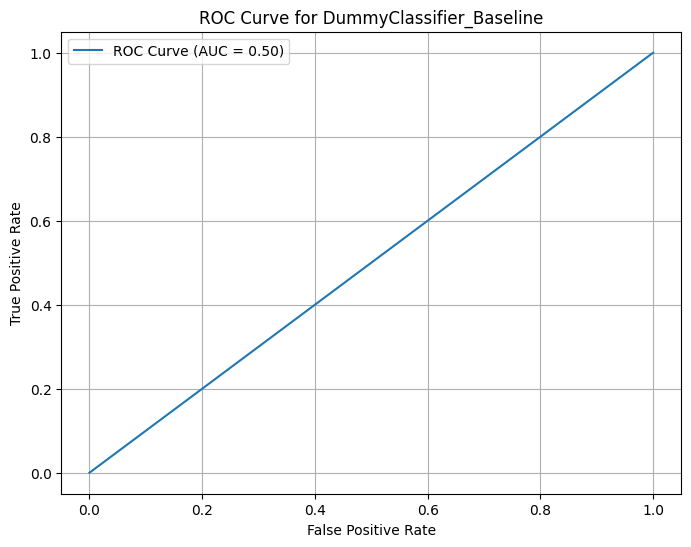

 DummyClassifier_Baseline enregistré dans MLFlow


In [11]:
# Paramètres du DummyClassifier
params = {"strategy": "most_frequent"}

# Exécution du tracking avec MLFlow
best_dummy = track_experiment(
    "DummyClassifier_Baseline",
    pipeline_dummy,
    params,
    X_train, y_train,
    X_test, y_test
)

In [12]:
from mlflow.tracking import MlflowClient

client = MlflowClient()

# Récupération de l'expérience MLFlow
experiment_name = "DummyClassifier_Baseline"
experiment = next((exp for exp in client.search_experiments() if exp.name == experiment_name), None)

if experiment:
    experiment_id = experiment.experiment_id
    runs = client.search_runs(experiment_ids=[experiment_id], order_by=["attributes.start_time desc"])
    
    # Affichage de toutes les métriques stockées dans MLFlow
    print(" Métriques enregistrées dans MLFlow :")
    for metric, value in runs[0].data.metrics.items():
        print(f"{metric}: {value:.4f}")

    # et du model
    model = mlflow.sklearn.load_model(runs[0].info.artifact_uri + "/model")
    print("\n Modèle enregistrées dans MLFlow :")
    print(model)

 Métriques enregistrées dans MLFlow :
accuracy: 0.9391
AUC: 0.5000
AUC_test: 0.5000
business_score: 1310.0000
F1: 0.0000
fit_time: 0.1575
prediction_time: 0.0010
threshold_optimal: 0.0000

 Modèle enregistrées dans MLFlow :
Pipeline(steps=[('smote', SMOTE(random_state=42)),
                ('dummy', DummyClassifier(strategy='most_frequent'))])


## 2. linear regression logistique

In [13]:
from sklearn.linear_model import LogisticRegression

# Pipeline avec Smote sur LogisticRegression
pipeline = Pipeline([
    ('smote', SMOTE(sampling_strategy='auto', random_state=42)),
    ('logistic', LogisticRegression(solver="liblinear", random_state=42))
])

# Hyperparamètres pour LogisticRegression
# Préfixé par model__ car pipline avec imblearn
param_grid = {
    'logistic__C': [0.01, 0.1, 1, 10, 100],
}

# GridSearchCV
grid_search = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    scoring={
        'AUC': 'roc_auc',
        'Accuracy': 'accuracy',
        'business_score': make_scorer(calculate_business_score, greater_is_better=False),
        'threshold_optimal': make_scorer(calculate_optimal_threshold, needs_proba=True),
        'F1': make_scorer(f1_score)
    },
    refit='business_score', 
    cv=stratified_kfold,
    n_jobs=-1,
    verbose=1
)

grid_search.fit(X_train, y_train)

# Meilleurs paramètres / résultats / scores
best_params = grid_search.best_params_
mean_auc = grid_search.cv_results_['mean_test_AUC'][grid_search.best_index_]
mean_business_score = abs(grid_search.cv_results_['mean_test_business_score'][grid_search.best_index_])
y_test_proba = grid_search.best_estimator_.predict_proba(X_test)[:, 1]
auc_test = roc_auc_score(y_test, y_test_proba)

print(f"\n Meilleurs paramètres : {best_params}")
print(f"\n Score AUC moyen (cross-val) : {mean_auc:.4f}")
print(f"Score AUC du fichier test : {auc_test:.4f}")
print(f"\n Score métier moyen (cross-val) : {mean_business_score:.4f}")
for i in range(n_splits):
    split_score = abs(grid_search.cv_results_[f'split{i}_test_business_score'][grid_search.best_index_])
    print(f"Score métier pour split {i} : {split_score:.4f}")

# Vérification du score retourné par la fonction en dehors de GridSearchCV
print("\n")
y_pred = grid_search.best_estimator_.predict(X_test)
print(f"Score métier réel sur le test set : {calculate_business_score(y_test, y_pred)}")

Fitting 5 folds for each of 5 candidates, totalling 25 fits

 Meilleurs paramètres : {'logistic__C': 10}

 Score AUC moyen (cross-val) : 0.6204
Score AUC du fichier test : 0.5977

 Score métier moyen (cross-val) : 1072.8000
Score métier pour split 0 : 1167.0000
Score métier pour split 1 : 1002.0000
Score métier pour split 2 : 1020.0000
Score métier pour split 3 : 1091.0000
Score métier pour split 4 : 1084.0000


Confusion Matrix:
[[1266  753]
 [  67   64]]
FN: 67, FP: 753, Cost: 1423
Score métier réel sur le test set : 1423


 Utilisation de l'expérience existante : LogisticRegression_Baseline (ID: 871764857391792836)
Confusion Matrix:
[[1266  753]
 [  67   64]]
FN: 67, FP: 753, Cost: 1423


2025/02/21 08:27:20 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


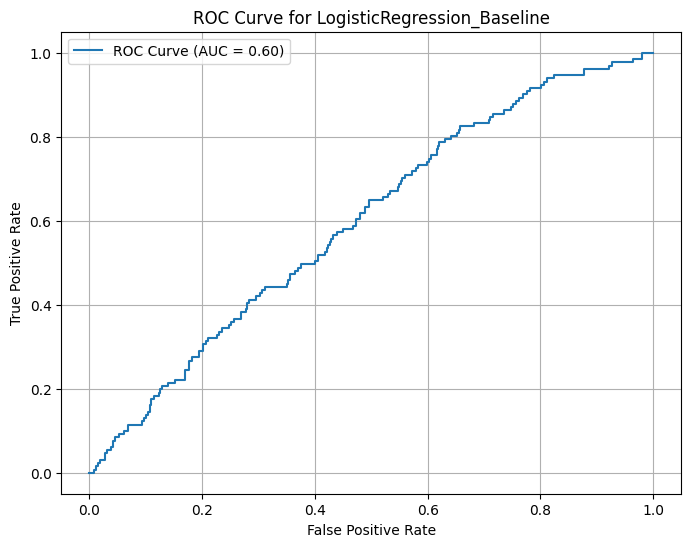

 LogisticRegression_Baseline enregistré dans MLFlow


Pipeline(steps=[('smote', SMOTE(random_state=42)),
                ('logistic',
                 LogisticRegression(C=10, random_state=42,
                                    solver='liblinear'))])

In [14]:
# Enregistrer les résultats dans MLFlow
params = {
    'sampling_strategy': 'auto',
    'C': best_params['logistic__C']
}

track_experiment(
    "LogisticRegression_Baseline",
    grid_search.best_estimator_,
    params,
    X_train, y_train,
    X_test, y_test
)

In [15]:
client = MlflowClient()

# Récupération de l'expérience MLFlow
experiment_name = "LogisticRegression_Baseline"
experiment = next((exp for exp in client.search_experiments() if exp.name == experiment_name), None)

if experiment:
    experiment_id = experiment.experiment_id
    runs = client.search_runs(experiment_ids=[experiment_id], order_by=["attributes.start_time desc"])
    
    # Affichage de toutes les métriques stockées dans MLFlow
    print(" Métriques enregistrées dans MLFlow :")
    for metric, value in runs[0].data.metrics.items():
        print(f"{metric}: {value:.4f}")

    # et du model
    model = mlflow.sklearn.load_model(runs[0].info.artifact_uri + "/model")
    print("\n Modèle enregistrées dans MLFlow :")
    print(model)

 Métriques enregistrées dans MLFlow :
accuracy: 0.6186
AUC: 0.5977
AUC_test: 0.5977
business_score: 1423.0000
F1: 0.1350
fit_time: 1.7630
prediction_time: 0.0130
threshold_optimal: 0.1585

 Modèle enregistrées dans MLFlow :
Pipeline(steps=[('smote', SMOTE(random_state=42)),
                ('logistic',
                 LogisticRegression(C=10, random_state=42,
                                    solver='liblinear'))])


## 3. RandomForestClassifier

In [16]:
from sklearn.ensemble import RandomForestClassifier

# Pipeline avec SMOTE et RandomForestClassifier
pipeline_rf = Pipeline([
    ('smote', SMOTE(sampling_strategy='auto', random_state=42)),
    ('rf', RandomForestClassifier(random_state=42))
])

# Hyperparamètres pour RandomForest
param_grid_rf = {
    'rf__n_estimators': [1, 10, 100],
    'rf__max_depth': [None, 1, 10, 50]
}

# GridSearchCV pour RandomForest
grid_search_rf = GridSearchCV(
    estimator=pipeline_rf,
    param_grid=param_grid_rf,
    scoring={
        'AUC': 'roc_auc',
        'Accuracy': 'accuracy',
        'business_score': make_scorer(calculate_business_score, greater_is_better=False),
        'threshold_optimal': make_scorer(calculate_optimal_threshold, needs_proba=True),
        'F1': make_scorer(f1_score)
    },
    refit='business_score',
    cv=stratified_kfold,
    n_jobs=-1,
    verbose=1
)

grid_search_rf.fit(X_train, y_train)

# Meilleurs paramètres / résultats / scores
best_params_rf = grid_search_rf.best_params_
mean_auc_rf = grid_search_rf.cv_results_['mean_test_AUC'][grid_search_rf.best_index_]
mean_business_score_rf = abs(grid_search_rf.cv_results_['mean_test_business_score'][grid_search_rf.best_index_])
y_test_proba_rf = grid_search_rf.best_estimator_.predict_proba(X_test)[:, 1]
auc_test_rf = roc_auc_score(y_test, y_test_proba_rf)


print(f"\n Meilleurs paramètres : {best_params_rf}")
print(f"\n Score AUC moyen (cross-val) : {mean_auc_rf:.4f}")
print(f"Score AUC du fichier test : {auc_test_rf:.4f}")
print(f"\n Score métier moyen (cross-val) : {mean_business_score_rf:.4f}")
for i in range(n_splits):
    split_score_rf = abs(grid_search_rf.cv_results_[f'split{i}_test_business_score'][grid_search_rf.best_index_])
    print(f"Score métier pour split {i} : {split_score_rf:.4f}")

# Vérification du score retourné par la fonction en dehors de GridSearchCV
print("\n")
y_pred = grid_search_rf.best_estimator_.predict(X_test)
print(f"\n Score métier réel sur le test set : {calculate_business_score(y_test, y_pred)}")

Fitting 5 folds for each of 12 candidates, totalling 60 fits

 Meilleurs paramètres : {'rf__max_depth': 10, 'rf__n_estimators': 100}

 Score AUC moyen (cross-val) : 0.6603
Score AUC du fichier test : 0.6477

 Score métier moyen (cross-val) : 1031.6000
Score métier pour split 0 : 1056.0000
Score métier pour split 1 : 999.0000
Score métier pour split 2 : 1031.0000
Score métier pour split 3 : 1035.0000
Score métier pour split 4 : 1037.0000


Confusion Matrix:
[[1995   24]
 [ 126    5]]
FN: 126, FP: 24, Cost: 1284

 Score métier réel sur le test set : 1284


 Utilisation de l'expérience existante : RandomForest_Baseline (ID: 979903023935882380)
Confusion Matrix:
[[1995   24]
 [ 126    5]]
FN: 126, FP: 24, Cost: 1284


2025/02/21 08:28:15 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


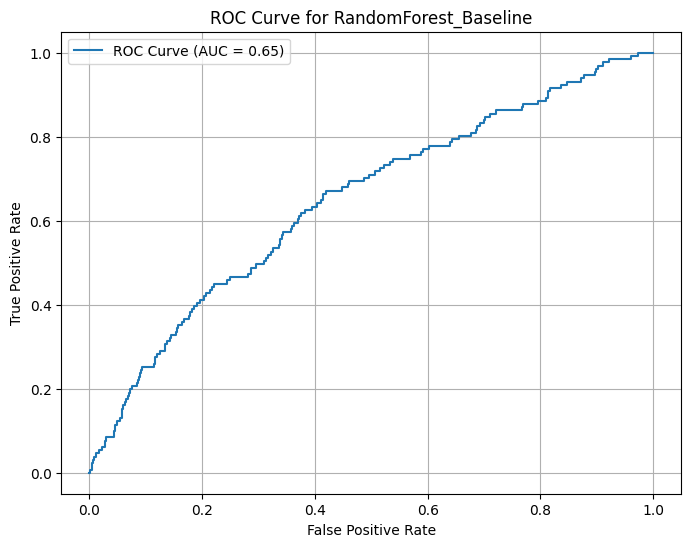

 RandomForest_Baseline enregistré dans MLFlow


Pipeline(steps=[('smote', SMOTE(random_state=42)),
                ('rf', RandomForestClassifier(max_depth=10, random_state=42))])

In [17]:
# Enregistrement dans MLFlow
params_rf = {
    'sampling_strategy': 'auto',
    'n_estimators': best_params_rf['rf__n_estimators'],
    'max_depth': best_params_rf['rf__max_depth']
}

track_experiment(
    "RandomForest_Baseline",
    grid_search_rf.best_estimator_,
    params_rf,
    X_train, y_train,
    X_test, y_test
)

In [18]:
client = MlflowClient()

# Récupération de l'expérience MLFlow
experiment_name = "RandomForest_Baseline"
experiment = next((exp for exp in client.search_experiments() if exp.name == experiment_name), None)

if experiment:
    experiment_id = experiment.experiment_id
    runs = client.search_runs(experiment_ids=[experiment_id], order_by=["attributes.start_time desc"])
    
    # Affichage de toutes les métriques stockées dans MLFlow
    print(" Métriques enregistrées dans MLFlow :")
    for metric, value in runs[0].data.metrics.items():
        print(f"{metric}: {value:.4f}")

    # et du model
    model = mlflow.sklearn.load_model(runs[0].info.artifact_uri + "/model")
    print("\n Modèle enregistrées dans MLFlow :")
    print(model)

 Métriques enregistrées dans MLFlow :
accuracy: 0.9302
AUC: 0.6477
AUC_test: 0.6477
business_score: 1284.0000
F1: 0.0625
fit_time: 7.5503
prediction_time: 0.0966
threshold_optimal: 0.0642

 Modèle enregistrées dans MLFlow :
Pipeline(steps=[('smote', SMOTE(random_state=42)),
                ('rf', RandomForestClassifier(max_depth=10, random_state=42))])


## 3. GradientBoostingClassifier

In [19]:
from sklearn.ensemble import GradientBoostingClassifier

# Pipeline avec SMOTE et GradientBoostingClassifier
pipeline_gb = Pipeline([
    ('smote', SMOTE(sampling_strategy='auto', random_state=42)),
    ('gb', GradientBoostingClassifier(random_state=42))
])

# Hyperparamètres pour GradientBoostingClassifier
param_grid_gb = {
    'gb__n_estimators': [10, 50, 100],
    'gb__max_depth': [10, 50, 100]
}

# GridSearchCV pour GradientBoostingClassifier
grid_search_gb = GridSearchCV(
    estimator=pipeline_gb,
    param_grid=param_grid_gb,
    scoring={
        'AUC': 'roc_auc',
        'Accuracy': 'accuracy',
        'business_score': make_scorer(calculate_business_score, greater_is_better=False),
        'threshold_optimal': make_scorer(calculate_optimal_threshold, needs_proba=True),
        'F1': make_scorer(f1_score)
    },
    refit='business_score',
    cv=stratified_kfold,
    n_jobs=-1,
    verbose=1
)

grid_search_gb.fit(X_train, y_train)

# Meilleurs paramètres / résultats / scores
best_params_gb = grid_search_gb.best_params_
mean_auc_gb = grid_search_gb.cv_results_['mean_test_AUC'][grid_search_gb.best_index_]
mean_business_score_gb = abs(grid_search_gb.cv_results_['mean_test_business_score'][grid_search_gb.best_index_])
y_test_proba_gb = grid_search_gb.best_estimator_.predict_proba(X_test)[:, 1]
auc_test_gb = roc_auc_score(y_test, y_test_proba_gb)


print(f"\n Meilleurs paramètres : {best_params_gb}")
print(f"\n Score AUC moyen (cross-val) : {mean_auc_gb:.4f}")
print(f"Score AUC du fichier test : {auc_test_gb:.4f}")
print(f"\n Score métier moyen (cross-val) : {mean_business_score_gb:.4f}")
for i in range(n_splits):
    split_score_gb = abs(grid_search_gb.cv_results_[f'split{i}_test_business_score'][grid_search_gb.best_index_])
    print(f"Score métier pour split {i} : {split_score_gb:.4f}")

# Vérification du score retourné par la fonction en dehors de GridSearchCV
print("\n")
y_pred = grid_search_gb.best_estimator_.predict(X_test)
print(f"\n Score métier réel sur le test set : {calculate_business_score(y_test, y_pred)}")

Fitting 5 folds for each of 9 candidates, totalling 45 fits

 Meilleurs paramètres : {'gb__max_depth': 50, 'gb__n_estimators': 50}

 Score AUC moyen (cross-val) : 0.5573
Score AUC du fichier test : 0.5589

 Score métier moyen (cross-val) : 1035.0000
Score métier pour split 0 : 1024.0000
Score métier pour split 1 : 1057.0000
Score métier pour split 2 : 993.0000
Score métier pour split 3 : 1028.0000
Score métier pour split 4 : 1073.0000


Confusion Matrix:
[[1859  160]
 [ 111   20]]
FN: 111, FP: 160, Cost: 1270

 Score métier réel sur le test set : 1270


 Utilisation de l'expérience existante : GradientBoosting_Baseline (ID: 197559212266179280)
Confusion Matrix:
[[1859  160]
 [ 111   20]]
FN: 111, FP: 160, Cost: 1270


2025/02/21 08:40:21 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


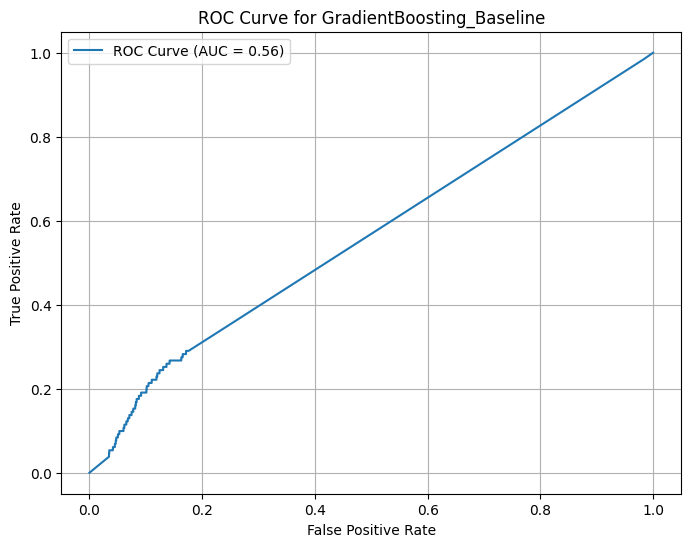

 GradientBoosting_Baseline enregistré dans MLFlow


Pipeline(steps=[('smote', SMOTE(random_state=42)),
                ('gb',
                 GradientBoostingClassifier(max_depth=50, n_estimators=50,
                                            random_state=42))])

In [20]:
# Enregistrement dans MLFlow
params_gb = {
    'sampling_strategy': 'auto',
    'n_estimators': best_params_gb['gb__n_estimators'],
    'max_depth': best_params_gb['gb__max_depth']
}

track_experiment(
    "GradientBoosting_Baseline",
    grid_search_gb.best_estimator_,
    params_gb,
    X_train, y_train,
    X_test, y_test
)

In [21]:
client = MlflowClient()

# Récupération de l'expérience MLFlow
experiment_name = "GradientBoosting_Baseline"
experiment = next((exp for exp in client.search_experiments() if exp.name == experiment_name), None)

if experiment:
    experiment_id = experiment.experiment_id
    runs = client.search_runs(experiment_ids=[experiment_id], order_by=["attributes.start_time desc"])
    
    # Affichage de toutes les métriques stockées dans MLFlow
    print(" Métriques enregistrées dans MLFlow :")
    for metric, value in runs[0].data.metrics.items():
        print(f"{metric}: {value:.4f}")

    # et du model
    model = mlflow.sklearn.load_model(runs[0].info.artifact_uri + "/model")
    print("\n Modèle enregistrées dans MLFlow :")
    print(model)

 Métriques enregistrées dans MLFlow :
accuracy: 0.8740
AUC: 0.5589
AUC_test: 0.5589
business_score: 1270.0000
F1: 0.1286
fit_time: 70.5615
prediction_time: 0.0355
threshold_optimal: 0.0033

 Modèle enregistrées dans MLFlow :
Pipeline(steps=[('smote', SMOTE(random_state=42)),
                ('gb',
                 GradientBoostingClassifier(max_depth=50, n_estimators=50,
                                            random_state=42))])


## Fine tuning du modèle RandomForest

In [22]:
from sklearn.ensemble import RandomForestClassifier

# Pipeline avec SMOTE et RandomForestClassifier
pipeline_rff = Pipeline([
    ('smote', SMOTE(sampling_strategy='auto', random_state=42)),
    ('rff', RandomForestClassifier(random_state=42))
])

# Hyperparamètres pour RandomForest
param_grid_rff = {
    'rff__n_estimators': [140,150,160],
    'rff__max_depth': [8],
    'rff__min_samples_split': [8, 10, 12],
    'rff__min_samples_leaf': [2, 3]
}

# GridSearchCV pour RandomForest
grid_search_rff = GridSearchCV(
    estimator=pipeline_rff,
    param_grid=param_grid_rff,
    scoring={
        'AUC': 'roc_auc',
        'Accuracy': 'accuracy',
        'business_score': make_scorer(calculate_business_score, greater_is_better=False),
        'threshold_optimal': make_scorer(calculate_optimal_threshold, needs_proba=True),
        'F1': make_scorer(f1_score)
    },
    refit='business_score',
    cv=stratified_kfold,
    n_jobs=-1,
    verbose=1
)

grid_search_rff.fit(X_train, y_train)

# Meilleurs paramètres / résultats / scores
best_params_rff = grid_search_rff.best_params_
mean_auc_rff = grid_search_rff.cv_results_['mean_test_AUC'][grid_search_rff.best_index_]
mean_business_score_rff = abs(grid_search_rff.cv_results_['mean_test_business_score'][grid_search_rff.best_index_])
y_test_proba_rff = grid_search_rff.best_estimator_.predict_proba(X_test)[:, 1]
auc_test_rff = roc_auc_score(y_test, y_test_proba_rff)

print(f"\n Meilleurs paramètres : {best_params_rff}")
print(f"\n Score AUC moyen (cross-val) : {mean_auc_rff:.4f}")
print(f"Score AUC du fichier test : {auc_test_rff:.4f}")
print(f"\n Score métier moyen (cross-val) : {mean_business_score_rff:.4f}")
for i in range(n_splits):
    split_score_rff = abs(grid_search_rff.cv_results_[f'split{i}_test_business_score'][grid_search_rff.best_index_])
    print(f"Score métier pour split {i} : {split_score_rff:.4f}")

# Vérification du score retourné par la fonction en dehors de GridSearchCV
print("\n")
y_pred = grid_search_rff.best_estimator_.predict(X_test)
print(f"\n Score métier réel sur le test set : {calculate_business_score(y_test, y_pred)}")

Fitting 5 folds for each of 18 candidates, totalling 90 fits

 Meilleurs paramètres : {'rff__max_depth': 8, 'rff__min_samples_leaf': 2, 'rff__min_samples_split': 10, 'rff__n_estimators': 160}

 Score AUC moyen (cross-val) : 0.6558
Score AUC du fichier test : 0.6297

 Score métier moyen (cross-val) : 1005.4000
Score métier pour split 0 : 983.0000
Score métier pour split 1 : 988.0000
Score métier pour split 2 : 1017.0000
Score métier pour split 3 : 1029.0000
Score métier pour split 4 : 1010.0000


Confusion Matrix:
[[1970   49]
 [ 124    7]]
FN: 124, FP: 49, Cost: 1289

 Score métier réel sur le test set : 1289


 Utilisation de l'expérience existante : RandomForest_FineTuned (ID: 592004699819887619)
Confusion Matrix:
[[1970   49]
 [ 124    7]]
FN: 124, FP: 49, Cost: 1289


2025/02/21 08:42:27 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


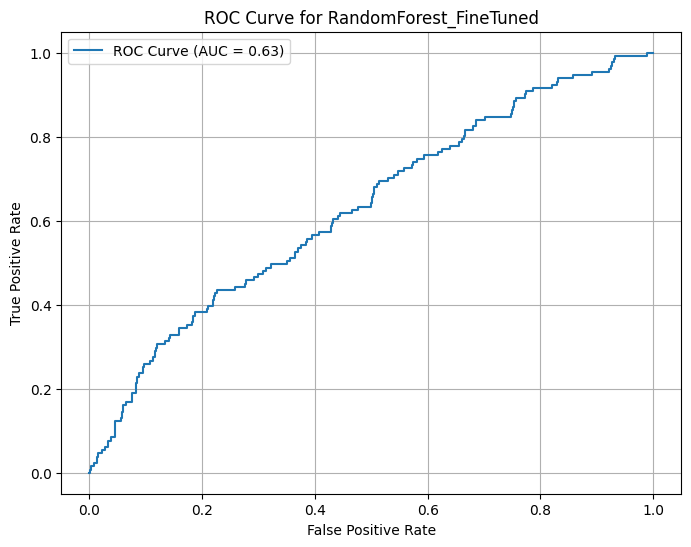

 RandomForest_FineTuned enregistré dans MLFlow


Pipeline(steps=[('smote', SMOTE(random_state=42)),
                ('rff',
                 RandomForestClassifier(max_depth=8, min_samples_leaf=2,
                                        min_samples_split=10, n_estimators=160,
                                        random_state=42))])

In [23]:
# Enregistrement dans MLFlow
params_rff = {
    'sampling_strategy': 'auto',
    'n_estimators': best_params_rff['rff__n_estimators'],
    'max_depth': best_params_rff['rff__max_depth'],
    'min_samples_split': best_params_rff['rff__min_samples_split'],
    'min_samples_leaf': best_params_rff['rff__min_samples_leaf']
}

track_experiment(
    "RandomForest_FineTuned",
    grid_search_rff.best_estimator_,
    params_rff,
    X_train, y_train,
    X_test, y_test
)

In [24]:
client = MlflowClient()

# Récupération de l'expérience MLFlow
experiment_name = "RandomForest_FineTuned"
experiment = next((exp for exp in client.search_experiments() if exp.name == experiment_name), None)

if experiment:
    experiment_id = experiment.experiment_id
    runs = client.search_runs(experiment_ids=[experiment_id], order_by=["attributes.start_time desc"])
    
    # Affichage de toutes les métriques stockées dans MLFlow
    print(" Métriques enregistrées dans MLFlow :")
    for metric, value in runs[0].data.metrics.items():
        print(f"{metric}: {value:.4f}")

    # et du model
    model = mlflow.sklearn.load_model(runs[0].info.artifact_uri + "/model")
    print("\n Modèle enregistrées dans MLFlow :")
    print(model)

 Métriques enregistrées dans MLFlow :
accuracy: 0.9195
AUC: 0.6297
AUC_test: 0.6297
business_score: 1289.0000
F1: 0.0749
fit_time: 7.2898
prediction_time: 0.0746
threshold_optimal: 0.0823

 Modèle enregistrées dans MLFlow :
Pipeline(steps=[('smote', SMOTE(random_state=42)),
                ('rff',
                 RandomForestClassifier(max_depth=8, min_samples_leaf=2,
                                        min_samples_split=10, n_estimators=160,
                                        random_state=42))])


## Feature importance
#### Feature importance globale

In [25]:
import shap
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Récupération du meilleur modèle entraîné depuis GridSearchCV
best_pipeline = grid_search_rf.best_estimator_

# Extraction du modèle RandomForest de ton pipeline
rf_model = best_pipeline.named_steps['rf']

# Calcul des SHAP values avec TreeExplainer
explainer = shap.TreeExplainer(rf_model)
shap_values = explainer.shap_values(X_test)

print(f"Type de shap_values : {type(shap_values)}")
print(f"Shape de shap_values : {np.shape(shap_values)}")  # Ajout pour voir la forme des SHAP values

# 🔹 Gestion de la classification binaire ou multi-classe
if isinstance(shap_values, list):  
    print(f"Nombre de classes détectées : {len(shap_values)}")
    # Prendre la classe positive si on est en classification binaire
    shap_values_class = shap_values[1] if len(shap_values) > 1 else shap_values[0]
else:
    shap_values_class = shap_values

print(f"Shape de shap_values_class : {np.shape(shap_values_class)}")  # Vérification


Type de shap_values : <class 'numpy.ndarray'>
Shape de shap_values : (2150, 243, 2)
Shape de shap_values_class : (2150, 243, 2)


In [26]:
# Calcul de l'importance des features en moyenne absolue
shap_importance = np.abs(shap_values_class).mean(axis=0)

print(f"Shape de shap_importance : {shap_importance.shape}")  # Vérification de la dimension
print(f"Shape de X_test.columns : {len(X_test.columns)}")  # Vérification du nombre de features

Shape de shap_importance : (243, 2)
Shape de X_test.columns : 243


In [27]:
# 🚀 Correction : Prendre la moyenne des SHAP values des classes
shap_importance_mean = shap_importance.mean(axis=1) 

print(f"Shape après moyennage : {shap_importance_mean.shape}") 

# Vérification avant DataFrame
if shap_importance_mean.shape[0] != len(X_test.columns):
    raise ValueError(f"Mismatch après correction : {shap_importance_mean.shape[0]} SHAP importances vs {len(X_test.columns)} features")

# Création du DataFrame des importances
feature_importance_df = pd.DataFrame({
    'Feature': X_test.columns,
    'SHAP Importance': shap_importance_mean
}).sort_values(by='SHAP Importance', ascending=False)

print("\nFeature Importance basée sur SHAP :")
print(feature_importance_df.head())

# # 📊 Affichage graphique de l'importance des features
# plt.figure(figsize=(10, 6))
# shap.summary_plot(shap_values_class, X_test, plot_type="bar")


Shape après moyennage : (243,)

Feature Importance basée sur SHAP :
                                               Feature  SHAP Importance
127  NAME_EDUCATION_TYPE_Secondary / secondary special         0.043831
122                           NAME_INCOME_TYPE_Working         0.038141
32                                        EXT_SOURCE_3         0.036119
108                                      CODE_GENDER_M         0.033772
31                                        EXT_SOURCE_2         0.023800


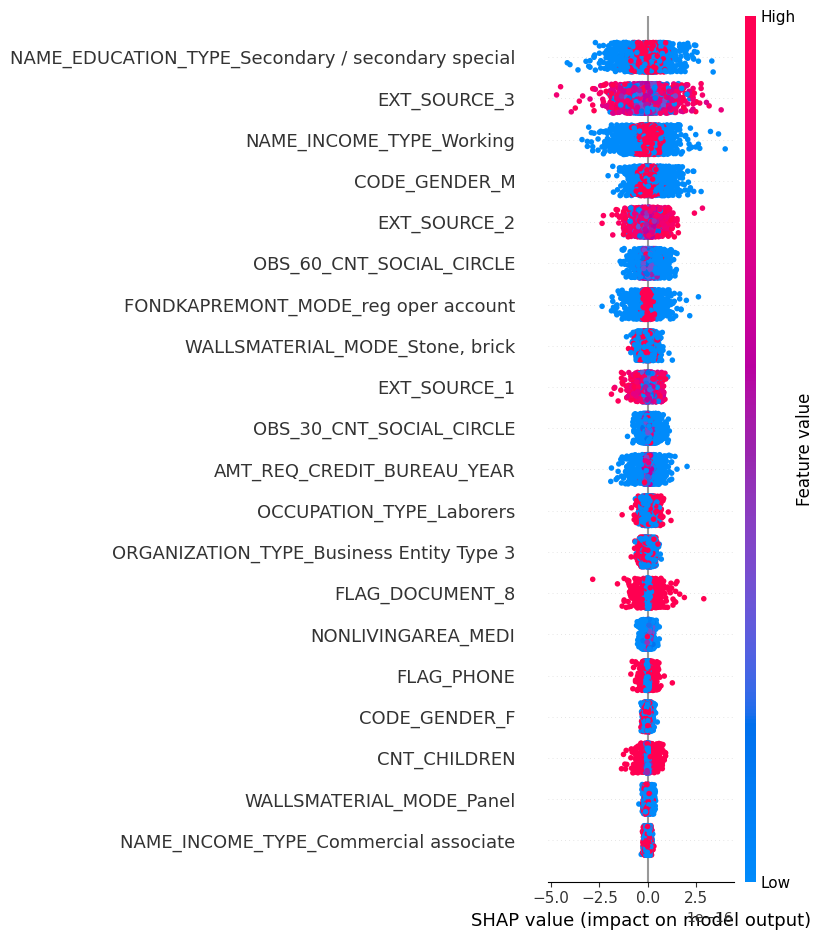

In [28]:
import shap
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# 🔹 Récupérer les indices des 20 features les plus importantes
top_n = 20
top_features = feature_importance_df.head(top_n)["Feature"].values  # Liste des features importantes

# 🔹 Sélectionner ces features dans X_test
X_test_top = X_test[top_features]  # Garde uniquement les features importantes

# 🔹 Sélectionner les indices des features importantes dans shap_values_class
feature_indices = [list(X_test.columns).index(feature) for feature in top_features]  
shap_values_top = shap_values_class[:, feature_indices]  # Filtrer les SHAP values

# 🔹 🔥 Correction : prendre la moyenne des valeurs SHAP sur toutes les classes pour éviter le double affichage
if shap_values_top.ndim == 3:  # Cas multi-classe (Shape: [samples, features, classes])
    shap_values_top = shap_values_top.mean(axis=2)  # Moyenne des classes pour éviter l'affichage sur plusieurs axes

# 📊 Affichage en summary plot avec les 20 features les plus importantes
shap.summary_plot(shap_values_top, X_test_top, max_display=20)


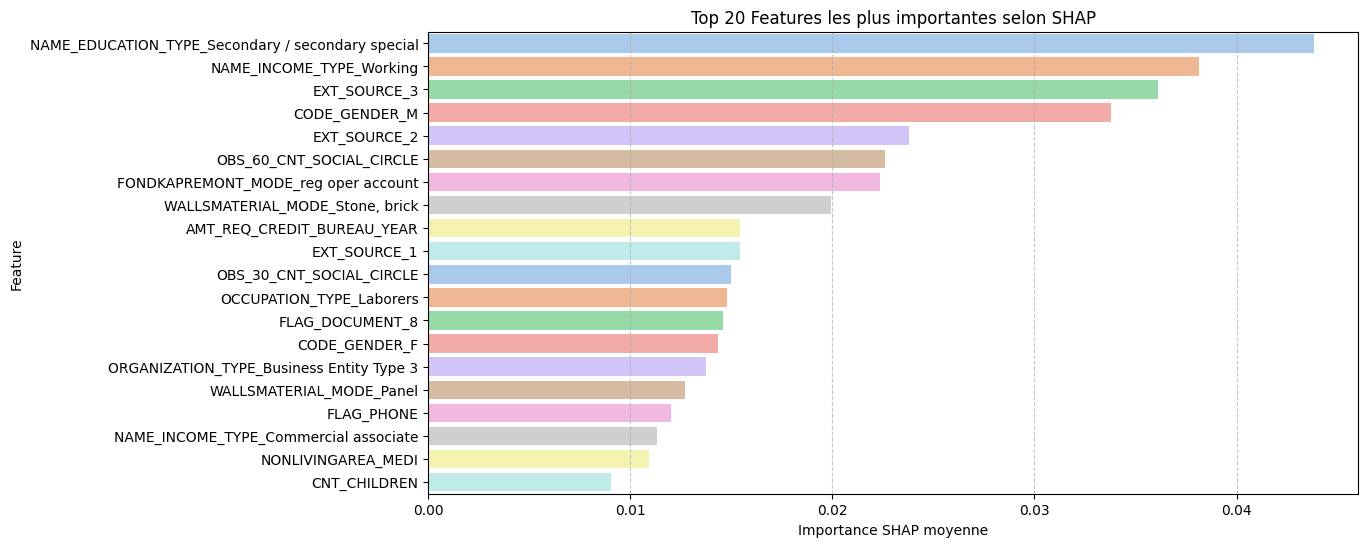

In [29]:
import seaborn as sns

# Sélection des 20 features les plus importantes
top_n = 20
top_features = feature_importance_df.head(top_n)

# 📊 Bar plot des 20 features les plus importantes
plt.figure(figsize=(12, 6))
sns.barplot(x="SHAP Importance", y="Feature", data=top_features, palette="pastel")

plt.xlabel("Importance SHAP moyenne")
plt.ylabel("Feature")
plt.title(f"Top {top_n} Features les plus importantes selon SHAP")
plt.grid(axis='x', linestyle="--", alpha=0.7)
plt.show()


##### Vérification avec le feature_importances_ de Random Forest

In [34]:
def plot_feature_importances(df):
    
    # Sort features according to importance
    df = df.sort_values('importance', ascending = False).reset_index()
    
    # Normalize the feature importances to add up to one
    df['importance_normalized'] = df['importance'] / df['importance'].sum()

    # Make a horizontal bar chart of feature importances
    plt.figure(figsize = (10, 6))
    ax = plt.subplot()
    
    # Need to reverse the index to plot most important on top
    ax.barh(list(reversed(list(df.index[:15]))), 
            df['importance_normalized'].head(15), 
            align = 'center', edgecolor = 'k')
    
    # Set the yticks and labels
    ax.set_yticks(list(reversed(list(df.index[:15]))))
    ax.set_yticklabels(df['feature'].head(15))
    
    # Plot labeling
    plt.xlabel('Normalized Importance'); plt.title('Feature Importances')
    plt.show()
    
    return df

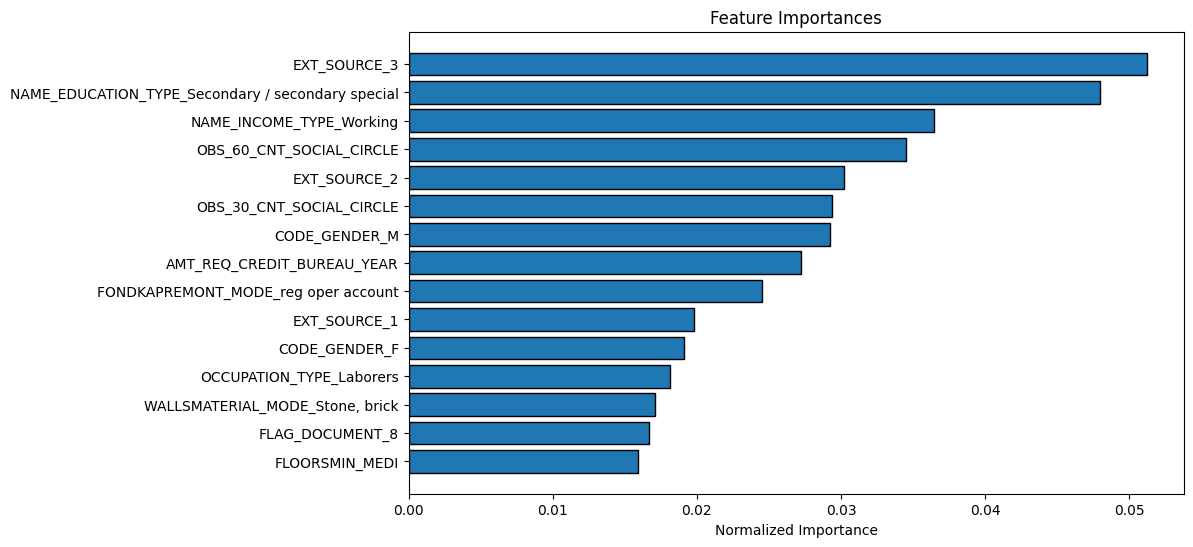

In [37]:
best_model_rff = best_pipeline.named_steps['rf']
domain_features_names = list(X_train.columns)
feature_importance_values_domain = best_model_rff.feature_importances_


feature_importances_domain = pd.DataFrame({'feature': domain_features_names, 'importance': feature_importance_values_domain})

feature_importances_sorted = plot_feature_importances(feature_importances_domain)

In [32]:
X.head()

,NAME_CONTRACT_TYPE,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,TOTALAREA_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,CODE_GENDER_F,CODE_GENDER_M,NAME_TYPE_SUITE_Children,NAME_TYPE_SUITE_Family,NAME_TYPE_SUITE_Group of people,NAME_TYPE_SUITE_Other_A,NAME_TYPE_SUITE_Other_B,"NAME_TYPE_SUITE_Spouse, partner",NAME_TYPE_SUITE_Unaccompanied,NAME_INCOME_TYPE_Businessman,NAME_INCOME_TYPE_Commercial associate,NAME_INCOME_TYPE_Pensioner,NAME_INCOME_TYPE_State servant,NAME_INCOME_TYPE_Student,NAME_INCOME_TYPE_Unemployed,NAME_INCOME_TYPE_Working,NAME_EDUCATION_TYPE_Academic degree,NAME_EDUCATION_TYPE_Higher education,NAME_EDUCATION_TYPE_Incomplete higher,NAME_EDUCATION_TYPE_Lower secondary,NAME_EDUCATION_TYPE_Secondary / secondary special,NAME_FAMILY_STATUS_Civil marriage,NAME_FAMILY_STATUS_Married,NAME_FAMILY_STATUS_Separated,NAME_FAMILY_STATUS_Single / not married,NAME_FAMILY_STATUS_Widow,NAME_HOUSING_TYPE_Co-op apartment,NAME_HOUSING_TYPE_House / apartment,NAME_HOUSING_TYPE_Municipal apartment,NAME_HOUSING_TYPE_Office apartment,NAME_HOUSING_TYPE_Rented apartment,NAME_HOUSING_TYPE_With parents,OCCUPATION_TYPE_Accountants,OCCUPATION_TYPE_Cleaning staff,OCCUPATION_TYPE_Cooking staff,OCCUPATION_TYPE_Core staff,OCCUPATION_TYPE_Drivers,OCCUPATION_TYPE_HR staff,OCCUPATION_TYPE_High skill tech staff,OCCUPATION_TYPE_IT staff,OCCUPATION_TYPE_Laborers,OCCUPATION_TYPE_Low-skill Laborers,OCCUPATION_TYPE_Managers,OCCUPATION_TYPE_Medicine staff,OCCUPATION_TYPE_Private service staff,OCCUPATION_TYPE_Realty agents,OCCUPATION_TYPE_Sales staff,OCCUPATION_TYPE_Secretaries,OCCUPATION_TYPE_Security staff,OCCUPATION_TYPE_Waiters/barmen staff,WEEKDAY_APPR_PROCESS_START_FRIDAY,WEEKDAY_APPR_PROCESS_START_MONDAY,WEEKDAY_APPR_PROCESS_START_SATURDAY,WEEKDAY_APPR_PROCESS_START_SUNDAY,WEEKDAY_APPR_PROCESS_START_THURSDAY,WEEKDAY_APPR_PROCESS_START_TUESDAY,WEEKDAY_APPR_PROCESS_START_WEDNESDAY,ORGANIZATION_TYPE_Advertising,ORGANIZATION_TYPE_Agriculture,ORGANIZATION_TYPE_Bank,ORGANIZATION_TYPE_Business Entity Type 1,ORGANIZATION_TYPE_Business Entity Type 2,ORGANIZATION_TYPE_Business Entity Type 3,ORGANIZATION_TYPE_Cleaning,ORGANIZATION_TYPE_Construction,ORGANIZATION_TYPE_Cult

#### Feature importance locale (du 1er élément)

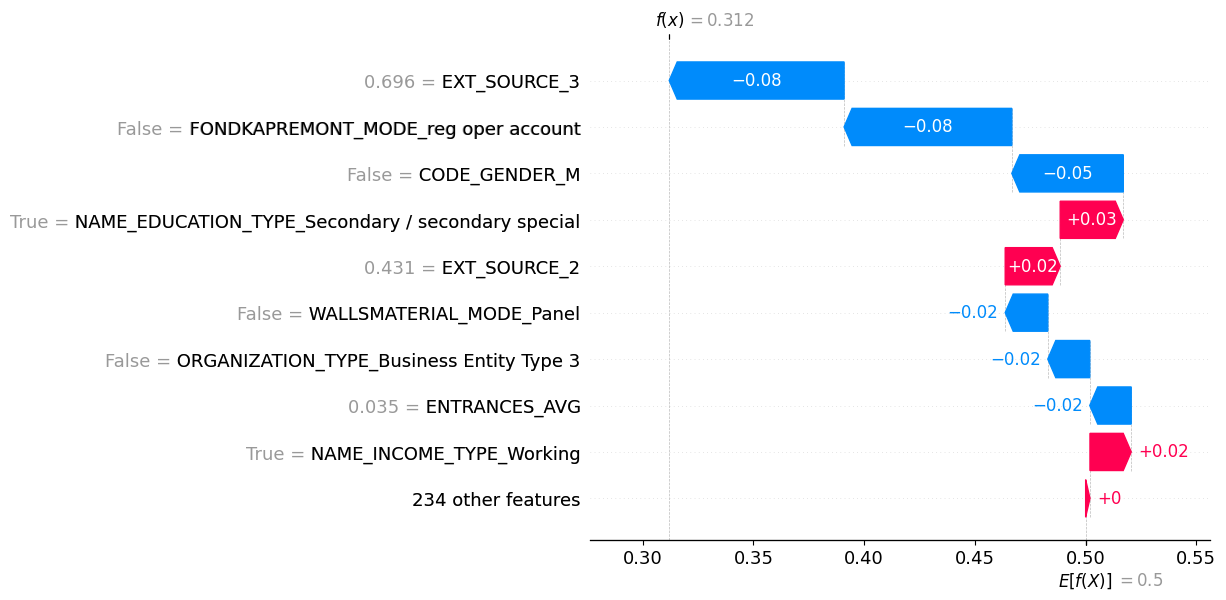

In [33]:
# 📌 Sélection du premier élément
index_sample = 0
sample = X_test.iloc[[index_sample]]  # Garder le format DataFrame

# 🔹 Récupération des SHAP values associées pour cet élément
shap_values_sample = shap_values_class[index_sample, :]  # Sélection des valeurs SHAP pour cet élément

# 🔹 Vérification et correction de la forme des SHAP values
if shap_values_sample.ndim == 2:  # Cas multi-classe
    shap_values_sample = shap_values_sample[:, 1]  # On prend la classe positive

# 🔹 Correction de base_values pour éviter l'erreur TypeError
base_value = explainer.expected_value
if isinstance(base_value, np.ndarray) or isinstance(base_value, list):  
    base_value = base_value[1] if len(base_value) > 1 else base_value[0]  # On prend la valeur de la classe positive
base_value = float(np.squeeze(base_value))  # Conversion en float pour éviter les erreurs

# 🔹 Création de l'explication SHAP
explanation = shap.Explanation(
    values=shap_values_sample, 
    base_values=base_value,  # Correction ici
    data=sample.iloc[0]
)

# 📊 Affichage du Waterfall Plot (Décomposition locale de la prédiction)
shap.waterfall_plot(explanation)


# IGNORER A PARTIR D'ICI

- Environnement GIT pour avoir plusieurs commit
- modifier model fine tuned par RandomForest
- Modifier SHAP global avec box plot
- Vérifier et corriger la feature importance locale aussi (pk les deux premier ont un impact autant signifiactif par rapport aux autres)

- API :
    -  

# Sauvegarde et Conclusion

Les résultats de cette analyse, ainsi que les modèles optimisés, sont sauvegardés pour un usage futur. 
Ils seront utilisés pour :
- Le déploiement de l'API de prédiction.
- La présentation des résultats dans le cadre de la soutenance.

### Étapes :
1. Sauvegarder les résultats des modèles et des expérimentations.
2. Finaliser le notebook pour qu’il soit prêt à être intégré dans le livrable final.
